## Multiplayer Proxy Failure _ Data analysis


In [1]:

import numpy as np
import pandas as pd
import matplotlib 

In [2]:
# use pandas to read filtered data
df = pd.read_csv('data_file_dump_proba.csv')

#fuse the two dataframes


pd.set_option('display.max_columns', None)

df["goal_improvement"] = df["maxed_goal_value"] - df["goal_base"]
df["delta_opti_goal"] = df["optimal_goal_value"] - df["goal_base"]
df["correlation_diff"] = df['correlation_on_max_proxy'] -  df['correlation_base'] 
df["proxy_improvement"] = df["maxed_proxy_value"] - df["proxy_base"]
df["D"] = df['goal_discard'] - df["proxy_discard"]
df['E'] = df["avg_number_of_edges"]
df['S'] = df["spectral_radius"]
df['N'] = df["n"]

sub_df = df[df["correlation_diff"].notna()]  ## It is normal that some 
sub_df.describe()

,n,trials,proxy_discard,goal_discard,measure_time,spectral_radius,alpha,avg_number_of_edges,correlation_std,maxed_goal_value,goal_base,maxed_proxy_value,proxy_base,correlation_on_max_proxy,correlation_base,optimal_goal_value,optimal_proxy_value,goal_improvement,delta_opti_goal,correlation_diff,proxy_improvement,D,E,S,N
count,10238.000000,10238.0,10238.0,10238.000000,10238.0,10238.000000,1.023800e+04,10238.000000,10238.000000,10238.000000,10238.000000,1.023800e+04,10238.000000,10238.000000,10238.000000,1.023800e+04,1.023800e+04,10238.000000,10238.000000,10238.000000,1.023800e+04,10238.000000,10238.000000,10238.000000,10238.000000
mean,480.068763,50.0,50.0,224.956046,50.0,1.874927,1.000000e-01,3.875464,0.401560,0.226610,0.001901,3.433238e-01,0.002220,0.644248,0.817656,2.651787e-01,2.651787e-01,0.224709,0.263278,-0.173408,3.411039e-01,174.956046,3.875464,1.874927,480.068763
std,343.176774,0.0,0.0,147.890223,0.0,0.739525,1.604351e-14,2.558846,0.136318,0.250383,0.042077,2.702129e-01,0.069372,0.321685,0.177561,2.496976e-01,2.496976e-01,0.251232,0.250517,0.225190,2.758834e-01,147.890223,2.558846,0.739525,343.176774
min,128.000000,50.0,50.0,50.000000,50.0,1.000000,1.000000e-01,1.500000,0.089462,-0.377242,-0.253172,1.052691e-07,-0.367500,-0.987843,0.201940,1.303085e-21,1.303085e-21,-0.365840,-0.132290,-1.979279,9.930840e-08,0.000000,1.500000,1.000000,128.000000
25%,256.000000,50.0,50.0,75.000000,50.0,1.125000,1.000000e-01,2.000000,0.303863,0.008724,-0.009132,5.324955e-02,-0.019077,0.433869,0.720565,1.478887e-02,1.478887e-02,0.008641,0.014980,-0.264944,5.145809e-02,25.000000,2.000000,1.125000,256.000000
50%,512.000000,50.0,50.0,150.000000,50.0,1.750000,1.000000e-01,4.000000,0.396780,0.150063,0.000048,3.525678e-01,0.000090,0.732676,0.872115,2.338241e-01,2.338241e-01,0.147390,0.229739,-0.097593,3.358631e-01,100.000000,4.000000,1.750000,512.000000
75%,896.000000,50.0,50.0,250.000000,50.0,2.000000,1.000000e-01,7.000000,0.490099,0.380258,0.011263,5.428696e-01,0.023739,0.914217,0.962470,4.303084e-01,4.303084e-01,0.379582,0.430870,-0.012376,5.428686e-01,200.000000,7.000000,2.000000,896.000000
max,1024.000000,50.0,50.0,450.000000,50.0,3.000000,1.000000e-01,8.000000,0.837826,1.000000,0.303525,9.983891e-01,0.433257,1.000000,1.000000,9.999996e-01,9.999996e-01,1.175052,1.175017,0.305589,1.249995e+00,400.000000,8.000000,3.000000,1024.000000


Beware, Na values for correlation_diff are ignored
4 4


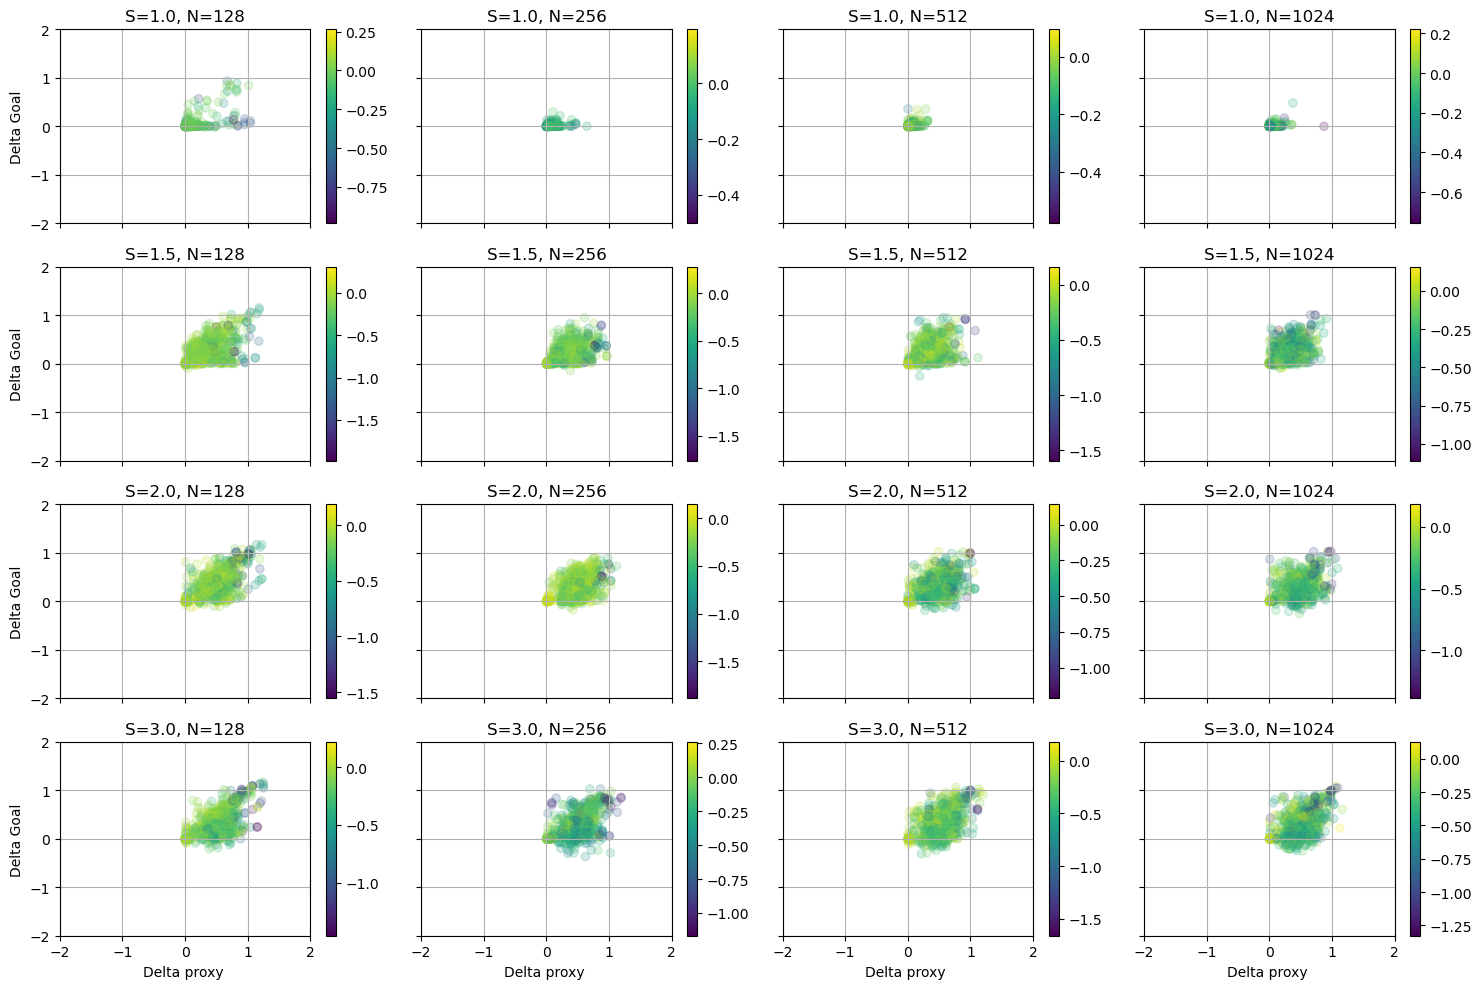

8160    -8.869694e-07
8161    -7.828977e-04
8162    -9.001837e-01
8163    -7.941682e-03
8164    -3.721570e-03
             ...     
10235   -1.640251e-01
10236   -4.556954e-01
10237   -5.915525e-01
10238   -6.741953e-01
10239   -3.010406e-01
Name: correlation_diff, Length: 640, dtype: float64


In [3]:
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


def plot_deltagoal_vs_deltaproxcorrelation_along(df, param1, param2):
    ''' find all possible values of param1 and param2 in the dataframe df
        and plot the delta goal vs delta proxy for each combination of param1 and param2
    '''
    print("Beware, Na values for correlation_diff are ignored")
    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param_combinations = list(product(param1_values, param2_values))
    print(len(param1_values), len(param2_values))
    fig, axes = plt.subplots(len(param1_values), len(param2_values), figsize=(15, 10), sharex=True, sharey=True)
    for (p1, p2) in param_combinations:
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        sub_df_no_na = sub_df[sub_df["correlation_diff"].notna()]
        sub_df_no_na = sub_df_no_na[sub_df_no_na["correlation_diff"] > -1.999]
        sub_df = sub_df_no_na
        
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]

        # scale all colors to be between -1 and 1
        
        

        ax.scatter(sub_df["proxy_improvement"],sub_df["goal_improvement"], alpha = 0.2,c=sub_df["correlation_diff"], cmap='viridis')

        #remove transparency from colorbar
        cbar = plt.colorbar(ax.collections[0], ax=ax)
        cbar.solids.set_alpha(1)

        ax.set_title(f'{param1}={p1}, {param2}={p2}')
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel('Delta Goal')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            #ax.set_xlabel('Delta goal in ideal case')
            ax.set_xlabel('Delta proxy ')

        ax.grid()
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
    plt.tight_layout()
    plt.show()
    print(sub_df["correlation_diff"])
    
plot_deltagoal_vs_deltaproxcorrelation_along(df, 'S', 'N')


Beware, Na values for correlation_diff are ignored
4 4


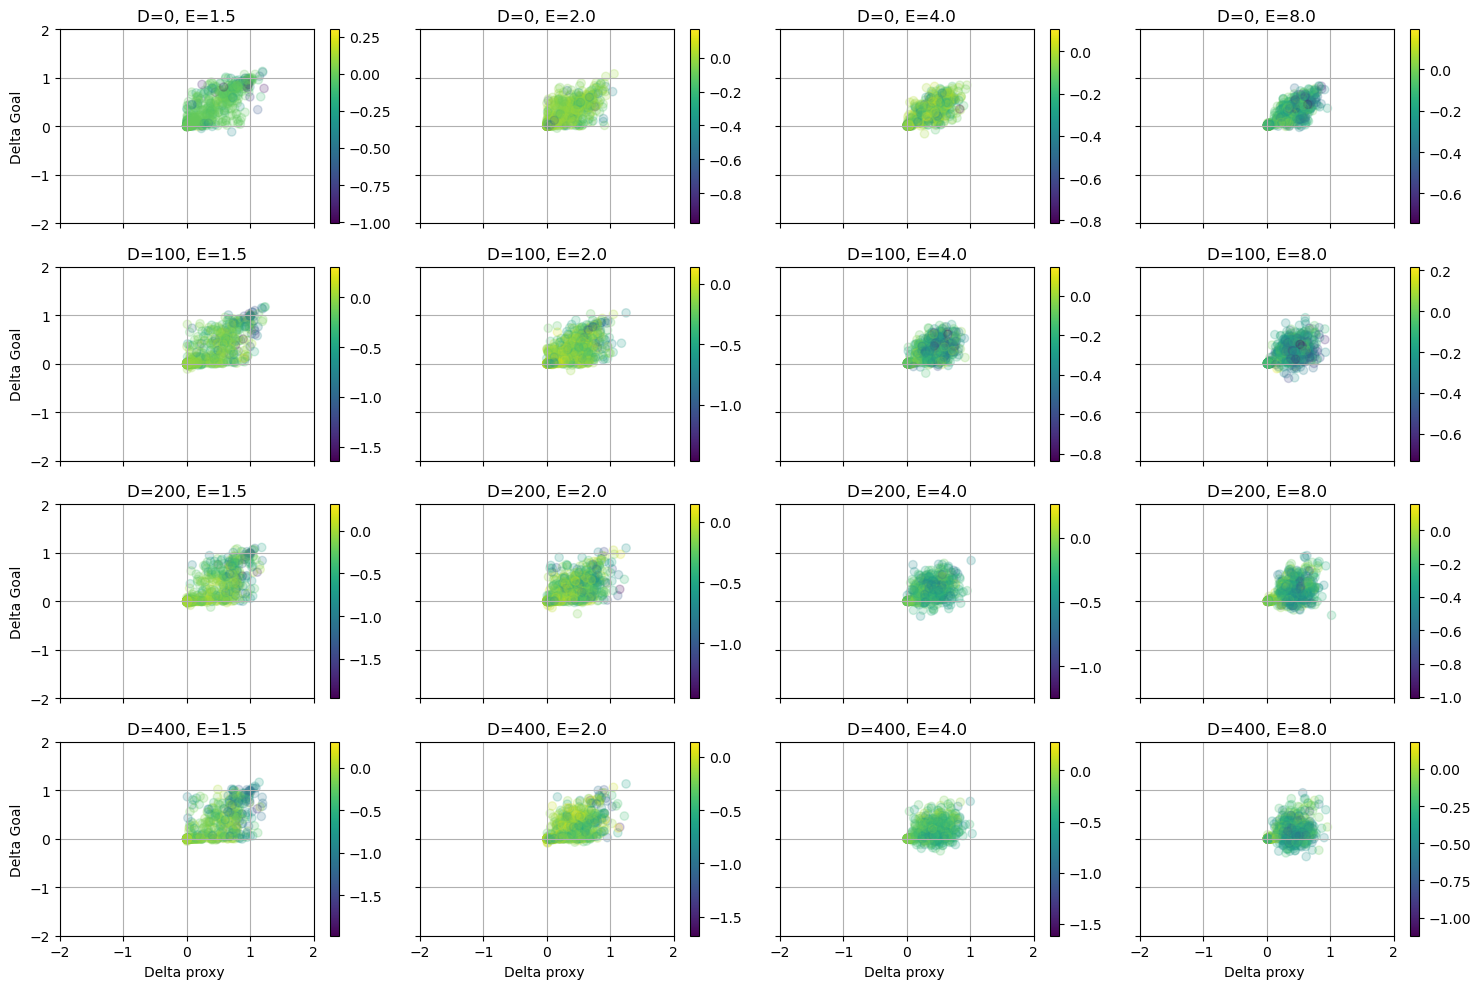

2040    -0.046137
2041     0.042758
2042    -0.042158
2043     0.024743
2044    -0.086873
           ...   
10235   -0.164025
10236   -0.455695
10237   -0.591553
10238   -0.674195
10239   -0.301041
Name: correlation_diff, Length: 640, dtype: float64


In [4]:
plot_deltagoal_vs_deltaproxcorrelation_along(df, "D", 'E')


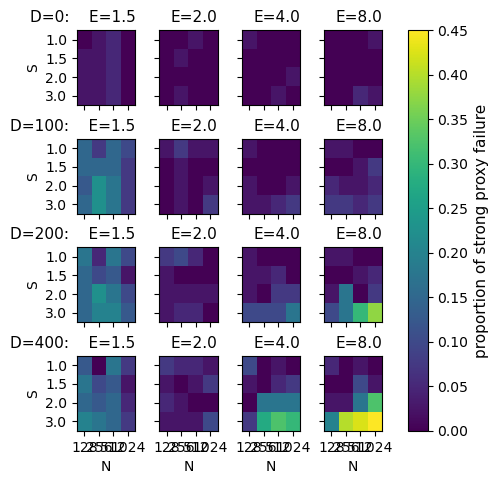

In [24]:
def plot_4params(df, param1, param2, param3, param4, weak = False):
    ''' find all possible values of param1 and param2 in the dataframe df
        then for each combination of param1 and param2, make a scatter plot along the other two parameters
        and color the points according to param_for_color
    '''

    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param3_values = df[param3].unique() 
    param4_values = df[param4].unique()
    cm = 1/2.54
    param_combinations = list(product(param1_values, param2_values))
    fig, axes = plt.subplots(len(param1_values), len(param2_values), figsize=(12*cm, 12*cm), sharex=True, sharey=True, layout='compressed')
    #search for the maximum and minimum of param_for_color
    param_range = range(len(param_combinations))
    Ms = [np.zeros((len(param3_values), len(param4_values))) for k in param_range]

    
    for k in param_range:
        (p1, p2 )= param_combinations[param_range[k]]
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]


        # create all combinations of param3 and param4
        
        param3_values = sub_df[param3].unique() # reverse the order
        param4_values = sub_df[param4].unique()
        param3_4_combinations = list(product(param3_values, param4_values))

        for (p3, p4) in param3_4_combinations:
            subsub_df = sub_df[(sub_df[param3] == p3) & (sub_df[param4] == p4)]
            
            prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 
            if weak:
                subsub_df = subsub_df[subsub_df.notna()]
                prop_failure = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

            Ms[k][param3_values.tolist().index(p3), param4_values.tolist().index(p4)] = prop_failure

        # make a colormap of M
        cmax = max([np.max(Ms[k]) for k in range(len(param_combinations))])
        cmin = min([np.min(Ms[k]) for k in range(len(param_combinations))])
    for k in param_range:
        (p1, p2 )= param_combinations[param_range[k]]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]
        ax.grid(False)
        c = ax.imshow(Ms[k], origin='lower', vmin=cmin, vmax=cmax, cmap='viridis', aspect='auto')

        #ax.scatter(grouped[param3], grouped[param4], alpha = 0.7, color = plt.cm.viridis((grouped[param_for_color] - min_color) / (max_color - min_color)))
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel(param3)
            ax.set_yticks([0,1,2,3],param3_values) 
            ax.set_title(f'{param1}={p1}:    {param2}={p2}', fontsize = 11, loc='right')
        else:
            ax.set_title(f'{param2}={p2}', fontsize = 11, loc='right')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel(param4)
            ax.set_xticks([0,1,2,3],param4_values)
        ax.invert_yaxis()
        




    # add a common colorbar between the maximum and minimum of param_for_color
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=cmin, vmax=cmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
    if weak:
        cbar.set_label("proportion of weak proxy failure", fontsize = 11)
    else:
        cbar.set_label("proportion of strong proxy failure", fontsize = 11)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig("test.pdf")
    plt.show()
#plot_4params(df, 'S', 'N', 'D', 'E', False)
plot_4params(df, 'D', 'E', 'S', 'N', False)

In [6]:
#plot_4params(df, 'S', 'N', 'D', 'E', True)

In [7]:
from sklearn.cross_decomposition import PLSRegression

X = [[0., 0., 1.], [1.,0.,9.], [2.,0.,62], [1.,1.,119]]

y = [0.1, 0.9, 6.2, 11.9]

pls2 = PLSRegression(n_components=2)

pls2.fit(X, y)
PLSRegression()

y_pred = pls2.predict(X)
pls2.coef_
pls2.transform(X)

array([[-1.31878811,  0.11072015],
       [-0.81608175, -0.18799199],
       [ 0.27420347,  0.0952922 ],
       [ 1.8606664 , -0.01802035]])

In [8]:
# create a new data base that groups collumns based of the parameters D E S N
unic = []
weak = False
param_list = ['D',"E","S","N"]
for k in param_list:
    unic.append( df[k].unique())

param_combinations = list(product(unic[0],unic[1],unic[2],unic[3] ))

Y = []
for k in range(len(param_combinations)):
    (p0,p1, p2,p3)= param_combinations[k]
    subsub_df = df[(df[param_list[0]] == p0) & (df[param_list[1]] == p1) &(df[param_list[2]] == p2) &(df[param_list[3]] == p3)]
    
    prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 
    if weak:
        subsub_df = subsub_df[subsub_df.notna()]
        prop_failure = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

    Y.append(prop_failure)

Y = np.asarray(Y)
Y = Y.reshape((-1,1))
Y_strong = Y

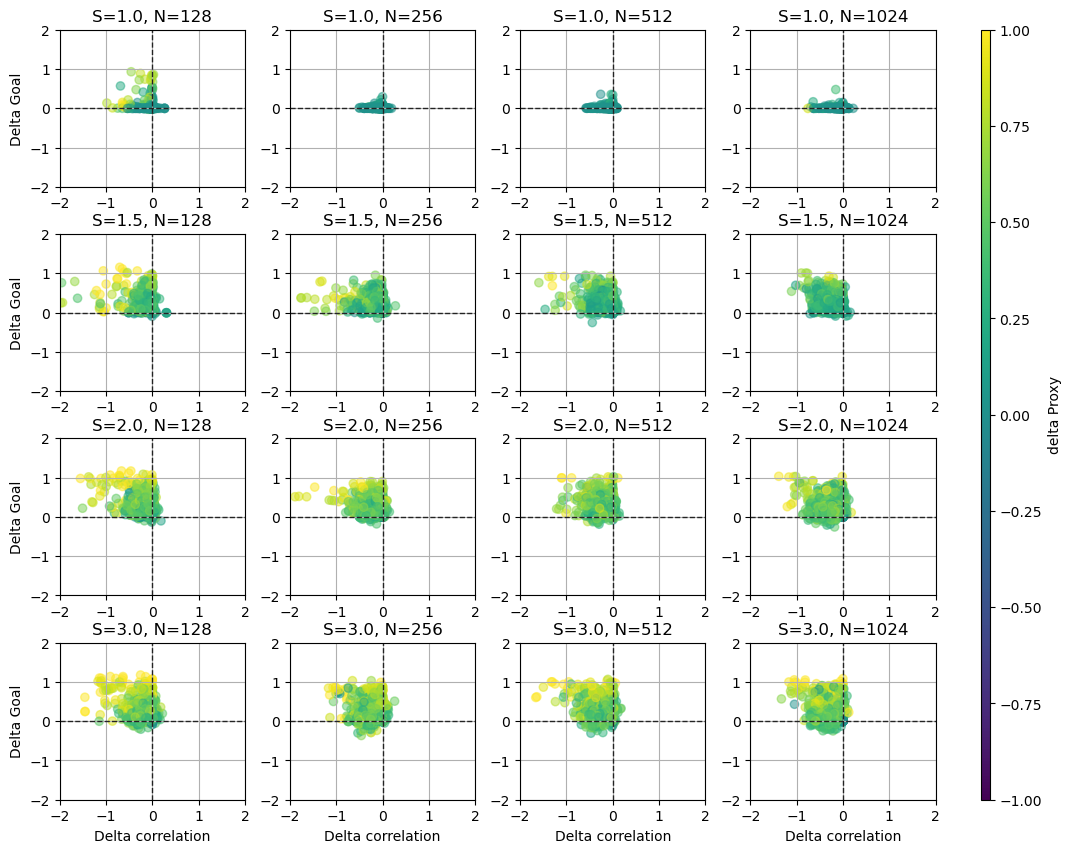

In [9]:
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
def plot_deltagoal_vs_deltaproxcorrelation_along(df, param1, param2):
    ''' find all possible values of param1 and param2 in the dataframe df
        and plot the delta goal vs delta proxy for each combination of param1 and param2.
        Colorcode the points by df['correlation_diff'].
    '''
    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param_combinations = list(product(param1_values, param2_values))
    # Create figure with space for colorbar
    fig = plt.figure(figsize=(12, 10))
    # Create a grid layout that reserves space for the colorbar
    gs = fig.add_gridspec(len(param1_values), len(param2_values) + 1,
                         width_ratios=[1]*len(param2_values) + [0.05],
                         hspace=0.3, wspace=0.3)
    # Store scatter plot collections for colorbar
    scatter_collections = []
    for (p1, p2) in param_combinations:
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = fig.add_subplot(gs[xi, yi])
        # scale colors in all subplots the same way
        scatter = ax.scatter(sub_df["correlation_diff"],sub_df["goal_improvement"], alpha = 0.5, c=sub_df['proxy_improvement'], cmap='viridis', vmin=-1, vmax=1)
        scatter_collections.append(scatter)
        na_df = sub_df[sub_df["correlation_diff"].isna()]
        #ax.scatter(na_df["goal_improvement"],[0]*len(na_df), color = "r", alpha = 0.3)
        ax.set_title(f'{param1}={p1}, {param2}={p2}')
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel('Delta Goal')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel('Delta correlation')
        ax.grid()
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        # Add black lines for x=0 and y=0
        ax.axhline(y=0, color='black', linewidth=1, alpha=0.8, linestyle='--')
        ax.axvline(x=0, color='black', linewidth=1, alpha=0.8, linestyle='--')
    # Add colorbar in the reserved space
    if scatter_collections:
        # Create colorbar axis spanning all rows
        cbar_ax = fig.add_subplot(gs[:, -1])
        cbar = plt.colorbar(scatter_collections[0], cax=cbar_ax, label='delta Proxy')
        cbar.solids.set_alpha(1)  # Make colorbar non-transparent
    fig.savefig(f'delta_goal_vs_delta_proxy_correlation_{param1}_{param2}.pdf', bbox_inches='tight')
    plt.show()
plot_deltagoal_vs_deltaproxcorrelation_along(df, 'S', 'N')

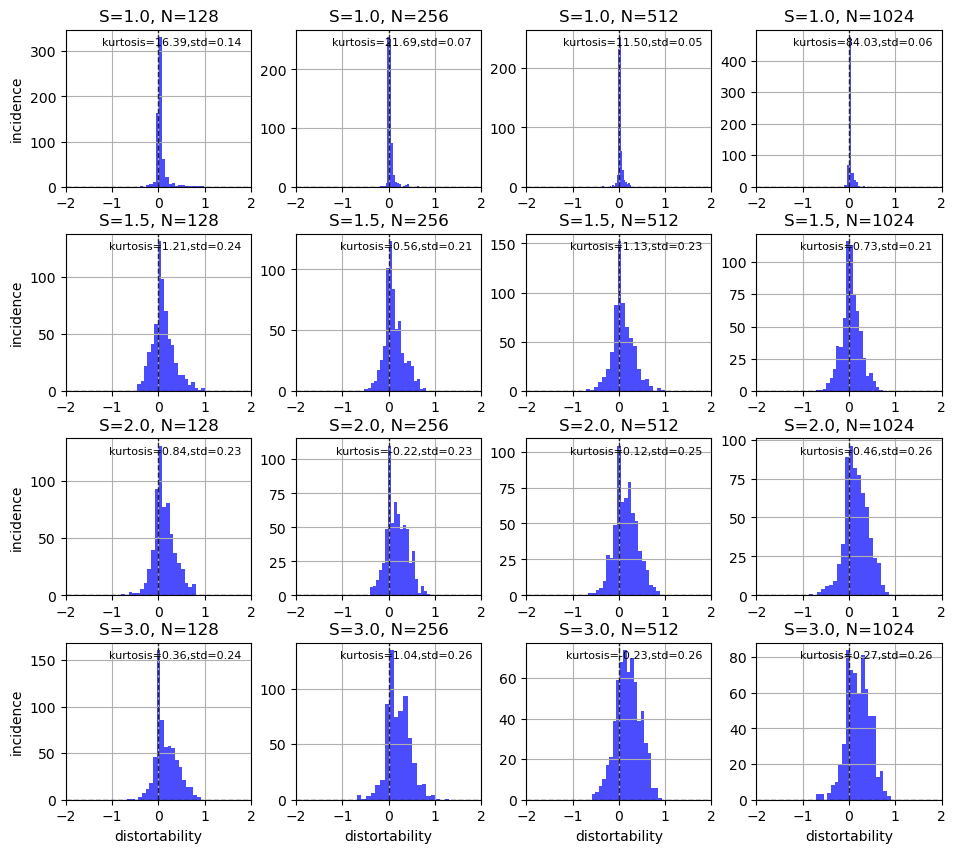

In [10]:
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from itertools import product
def plot_deltagoal_vs_deltaproxcorrelation_along(df, param1, param2):
    ''' find all possible values of param1 and param2 in the dataframe df
        and plot the delta goal vs delta proxy for each combination of param1 and param2.
        Colorcode the points by df['correlation_diff'].
    '''
    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param_combinations = list(product(param1_values, param2_values))
    # Create figure with space for colorbar
    fig = plt.figure(figsize=(12, 10))  
    # Create a grid layout that reserves space for the colorbar
    gs = fig.add_gridspec(len(param1_values), len(param2_values) + 1,
                         width_ratios=[1]*len(param2_values) + [0.05],
                         hspace=0.3, wspace=0.3)
    # Store scatter plot collections for colorbar
    scatter_collections = []
    for (p1, p2) in param_combinations:
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = fig.add_subplot(gs[xi, yi])
        # scale colors in all subplots the same way
        #scatter = ax.scatter(sub_df["correlation_diff"],sub_df['proxy_improvement'] - sub_df["goal_improvement"], alpha = 0.5, c=sub_df['proxy_improvement'], cmap='viridis', vmin=-1, vmax=1)
        #scatter_collections.append(scatter)
        ax.hist(sub_df['proxy_improvement'] - sub_df["goal_improvement"], bins=20, color='blue', alpha=0.7)
        #write the kurtosis of the histogram in the top right corner
        
        kurt = kurtosis(sub_df['proxy_improvement'] - sub_df["goal_improvement"], fisher=True, bias=False)
        std = np.std(sub_df['proxy_improvement'] - sub_df["goal_improvement"])
        ax.text(0.95, 0.95, f'kurtosis={kurt:.2f},std={std:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right')

        na_df = sub_df[sub_df["correlation_diff"].isna()]
        #ax.scatter(na_df["goal_improvement"],[0]*len(na_df), color = "r", alpha = 0.3)
        ax.set_title(f'{param1}={p1}, {param2}={p2}')
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel('incidence')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel('distortability')
        ax.grid()
        ax.set_xlim(-2, 2)
        #ax.set_ylim(-2, 2)
        # Add black lines for x=0 and y=0
        ax.axhline(y=0, color='black', linewidth=1, alpha=0.8, linestyle='--')
        ax.axvline(x=0, color='black', linewidth=1, alpha=0.8, linestyle='--')
    # Add colorbar in the reserved space
    if scatter_collections:
        # Create colorbar axis spanning all rows
        cbar_ax = fig.add_subplot(gs[:, -1])
        cbar = plt.colorbar(scatter_collections[0], cax=cbar_ax, label='delta Proxy')
        cbar.solids.set_alpha(1)  # Make colorbar non-transparent
    fig.savefig(f'delta_goal_vs_delta_proxy_correlation_{param1}_{param2}.pdf', bbox_inches='tight')
    plt.show()
plot_deltagoal_vs_deltaproxcorrelation_along(df, 'S', 'N')

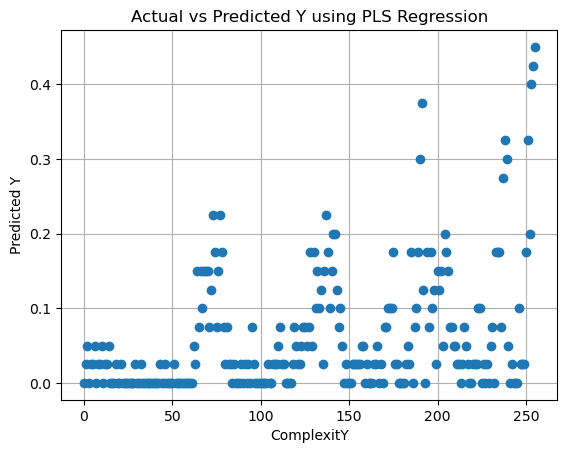

In [11]:
a = Y_strong.flatten()

plt.plot([k for k in range(256)],a, 'o')
plt.xlabel('ComplexitY')
plt.ylabel('Predicted Y')
plt.title('Actual vs Predicted Y using PLS Regression')
plt.grid()
plt.show()

In [12]:
# create a new data base that groups collumns based of the parameters D E S N
unic = []
weak = False
txttitle = "Strong"
if weak :
    txttitle = "Weak"

param_list = ['D',"E","S","N"]
for k in param_list:
    unic.append( df[k].unique())

param_combinations = list(product(unic[0],unic[1],unic[2],unic[3] ))

Ystronk = [[] for k in range(17)]
Yweak = [[] for k in range(17)]
for k in range(len(param_combinations)):
    (p0,p1, p2,p3)= param_combinations[k]
    complexity_class = sum([1+unic[i].tolist().index(param_combinations[k][i]) for i in range(4)])
    subsub_df = df[(df[param_list[0]] == p0) & (df[param_list[1]] == p1) &(df[param_list[2]] == p2) &(df[param_list[3]] == p3)]
    
    prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 

    subsub_df = subsub_df[subsub_df.notna()]
    prop_failur_weak = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

    Ystronk[complexity_class].append(prop_failure)
    Yweak[complexity_class].append(prop_failur_weak)

Y2stronk =  [np.mean(Ystronk[k]) for k in range(len(Ystronk))]
Y2stronk = Y2stronk[4:] # ignore the first four values
std2stronk = [np.sqrt((Y2stronk[k]) * (1 - (Y2stronk[k])) / len(Y2stronk))  for k in range(len(Y2stronk))]

Y2weak =  [np.mean(Yweak[k]) for k in range(len(Yweak))]
Y2weak = Y2weak[4:] # ignore the first four values
std2weak = [np.sqrt((Y2weak[k]) * (1 - (Y2weak[k])) / len(Y2weak))  for k in range(len(Y2weak))]



/home/paulbanse/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paulbanse/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


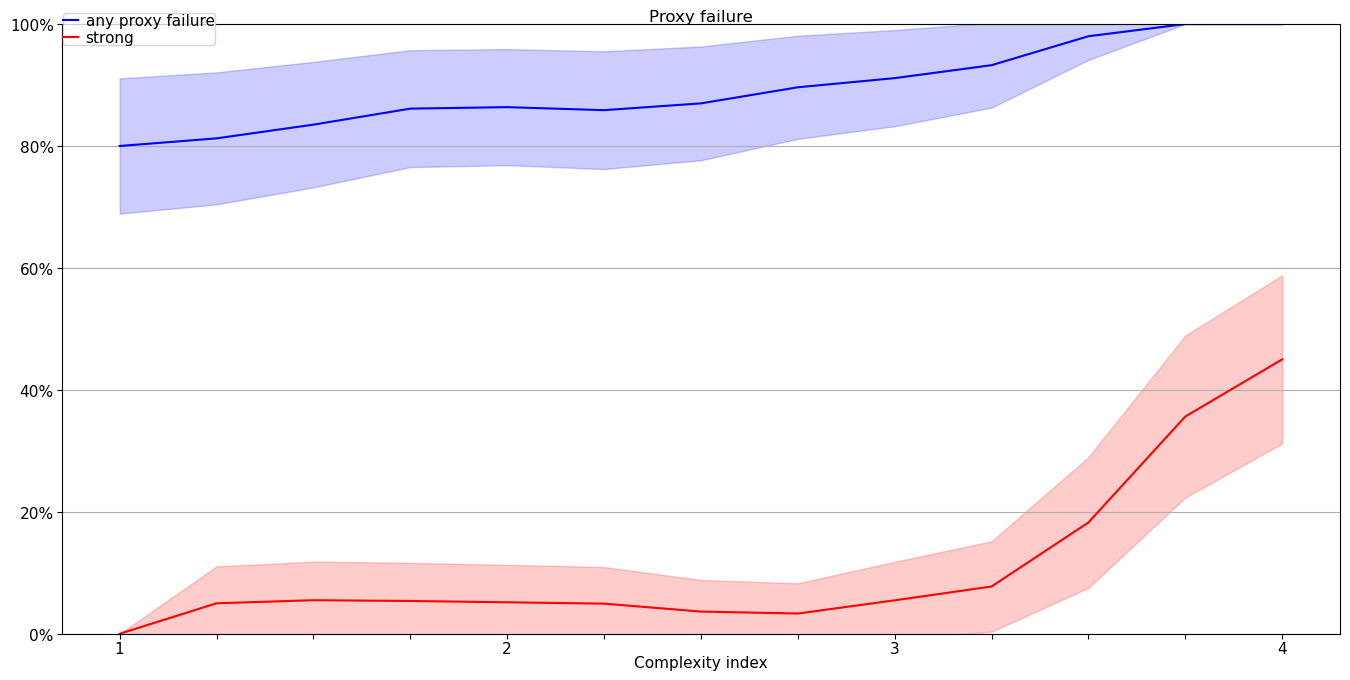

In [13]:
from IPython.display import SVG, display
import io

a = Y_strong.flatten()
X_scaled = np.array(X)
X_scaled01 = (X_scaled - X_scaled.min(axis=0)) / (X_scaled.max(axis=0) - X_scaled.min(axis=0))

Xes = [k/4 for k in range(4,17)]
Xlab = [str(int(k/4))*(int(k/4)== k/4)+'' for k in range(4,17)]

cm = 1/2.54
fig, ax = plt.subplots(figsize=(17*2*cm, 17*cm),layout='compressed')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.fill_between(Xes, np.array(Y2stronk)-np.array(std2stronk), np.array(Y2stronk)+np.array(std2stronk), color='r', alpha=0.2)
plt.fill_between(Xes, np.array(Y2weak)-np.array(std2weak), np.array(Y2weak)+np.array(std2weak), color='b', alpha=0.2)
plt.plot(Xes, Y2weak, '-', color='b', label = 'any proxy failure')
plt.plot(Xes, Y2stronk, '-', color='r', label="strong")
plt.xlabel('Complexity index', fontsize = 11, labelpad=-1)
plt.title('Proxy failure', fontsize = 12,pad=2 )
plt.ylim(0,1)
plt.yticks([0,0.2,0.4,0.6,0.8,1], ['0%','20%','40%','60%','80%','100%'], fontsize = 11)
ax.tick_params(axis='y', which='major', pad=2)
ax.tick_params(axis='x', which='major', pad=2)
plt.xticks(Xes, labels = Xlab, fontsize = 11)

plt.legend(fontsize = 11, loc = 'upper left', bbox_to_anchor=(-0.005,1.03), borderpad=0,labelspacing=0.1, handlelength=1, handletextpad=0.5)
plt.savefig("test.svg")
plt.show()




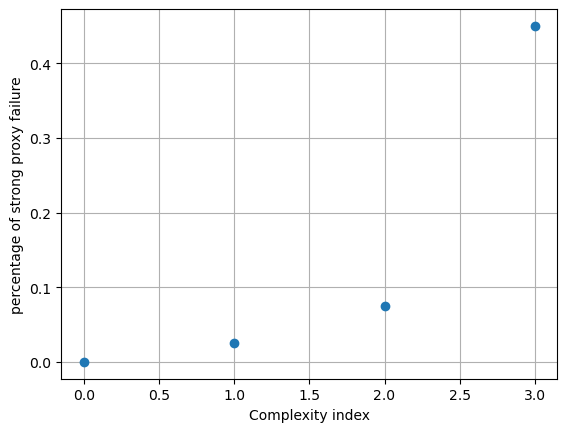

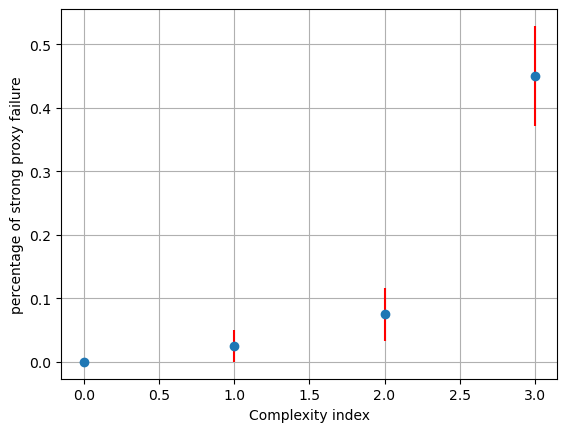

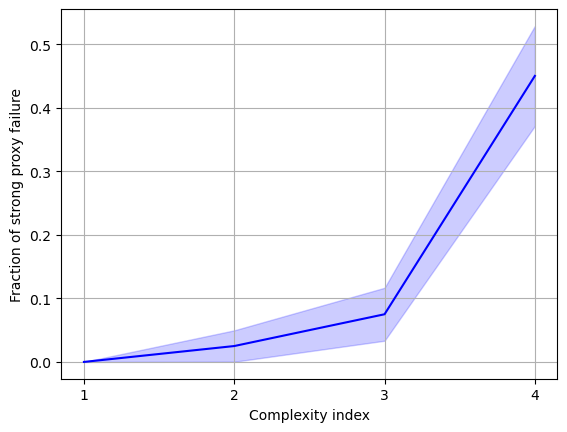

In [14]:
# create a new data base that groups collumns based of the parameters D E S N
unic = []
weak = False
param_list = ['D',"E","S","N"]
for k in param_list:
    unic.append( df[k].unique())

param_combinations = list(product(unic[0],unic[1],unic[2],unic[3] ))

Y = [[] for k in range(len(param_combinations))]

Y3 =  []

for k in range(4):
    subsub_df = df[(df[param_list[0]] == unic[0][k]) & (df[param_list[1]] == unic[1][k]) &(df[param_list[2]] == unic[2][k]) &(df[param_list[3]] == unic[3][k])]
    
    prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 
    if weak:
        subsub_df = subsub_df[subsub_df.notna()]
        prop_failure = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

    Y3.append(prop_failure)

plt.plot( Y3, 'o')
plt.xlabel('Complexity index')
plt.ylabel('percentage of strong proxy failure')
plt.grid()
plt.show()

# compute 


import matplotlib.pyplot as plt
import numpy as np
means = [np.mean(Y3[k]) for k in range(len(Y3))]
stds = [np.sqrt((Y3[k]) * (1 - (Y3[k])) / 40)  for k in range(len(Y3))]
plt.errorbar([k for k in range(4)], means, yerr=stds, fmt='o', ecolor='r', capthick=2)
plt.xlabel('Complexity index')
plt.ylabel('percentage of strong proxy failure')
plt.grid()
plt.show()

# can you link the error bars into a area and the dots into a line  plot?
import matplotlib.pyplot as plt
import numpy as np
means = [np.mean(Y3[k]) for k in range(len(Y3))]
stds = [np.sqrt((Y3[k]) * (1 - (Y3[k])) / 40)  for k in range(len(Y3))]
plt.fill_between([k+1 for k in range(4)], np.array(means)-np.array(stds), np.array(means)+np.array(stds), color='b', alpha=0.2)
plt.plot([k+1 for k in range(4)], means, '-', color='b')
plt.xlabel('Complexity index')
plt.ylabel('Fraction of strong proxy failure')
plt.xticks([k+1 for k in range(4)])
plt.grid()
plt.show()


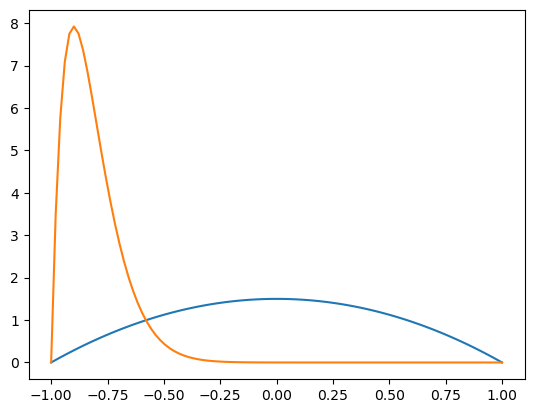

In [15]:
# write a script to use beta distribution to make samples between 1 and -1

from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
a, b = 2,2  # shape parameters
x = np.linspace(0, 1, 100)
y = beta.pdf(x, a, b)
a2, b2 = 2,20
y2 = beta.pdf(x, a2, b2)
a3, b3 = 20,2
y3 = beta.pdf(x, a3, b3)
X = x * 2 - 1
plt.plot(X, y, label=f'Beta({a},{b})')
plt.plot(X, y2, label=f'Beta({a2},{b2})')
#plt.plot(X, y3, label=f'Beta({a3},{b3})')
plt.show()

In [ ]:
df.iloc[1,] 

n                                                                                128
trials                                                                            50
proxy_discard                                                                     50
goal_discard                                                                      50
measure_time                                                                      50
spectral_radius                                                                  1.0
alpha                                                                            0.1
avg_number_of_edges                                                              1.5
correlation_std                                                             0.221044
bin_indices_on_base_correlation    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
maxed_goal_value                                                            0.030316
goal_base                                                        

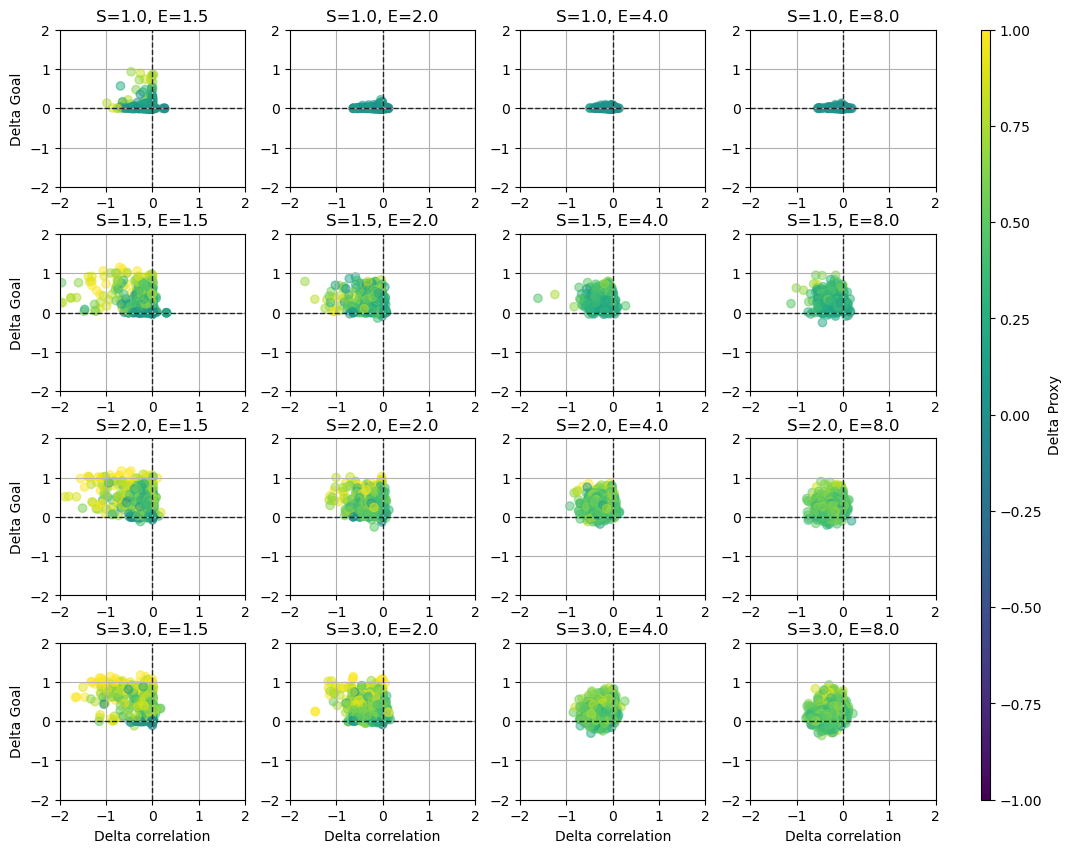

In [26]:



                
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
def plot2D_func(df, param1, param2,function_line):
    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param_combinations = list(product(param1_values, param2_values))
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(len(param1_values), len(param2_values) + 1,
                         width_ratios=[1]*len(param2_values) + [0.05],
                         hspace=0.3, wspace=0.3)

    collections = []
    for (p1, p2) in param_combinations:
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = fig.add_subplot(gs[xi, yi])
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        # scale colors in all subplots the same way
        scatter, X_axis,Y_axis,Z_axis = function_line(ax, sub_df)
        collections.append(scatter)
        na_df = sub_df[sub_df["correlation_diff"].isna()]
        #ax.scatter(na_df["goal_improvement"],[0]*len(na_df), color = "r", alpha = 0.3)
        ax.set_title(f'{param1}={p1}, {param2}={p2}')
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel(Y_axis)
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel(X_axis)
        ax.grid()
        # Add black lines for x=0 and y=0
        ax.axhline(y=0, color='black', linewidth=1, alpha=0.8, linestyle='--')
        ax.axvline(x=0, color='black', linewidth=1, alpha=0.8, linestyle='--')
    # Add colorbar in the reserved space
    if Z_axis:
        # Create colorbar axis spanning all rows
        cbar_ax = fig.add_subplot(gs[:, -1])
        cbar = plt.colorbar(collections[0], cax=cbar_ax, label=Z_axis)
        cbar.solids.set_alpha(1)  # Make colorbar non-transparent
    fig.savefig(f'delta_goal_vs_delta_proxy_correlation_{param1}_{param2}.pdf', bbox_inches='tight')
    plt.show()

def function_scatter(ax, sub_df):
    scatter = ax.scatter(sub_df["correlation_diff"],sub_df["goal_improvement"], alpha = 0.5, c=sub_df['proxy_improvement'], cmap='viridis', vmin=-1, vmax=1)
    X_axis = 'Delta correlation'
    Y_axis = 'Delta Goal'
    Z_axis = 'Delta Proxy'
    return scatter, X_axis,Y_axis,Z_axis
plot2D_func(df, 'S', 'E', function_scatter)

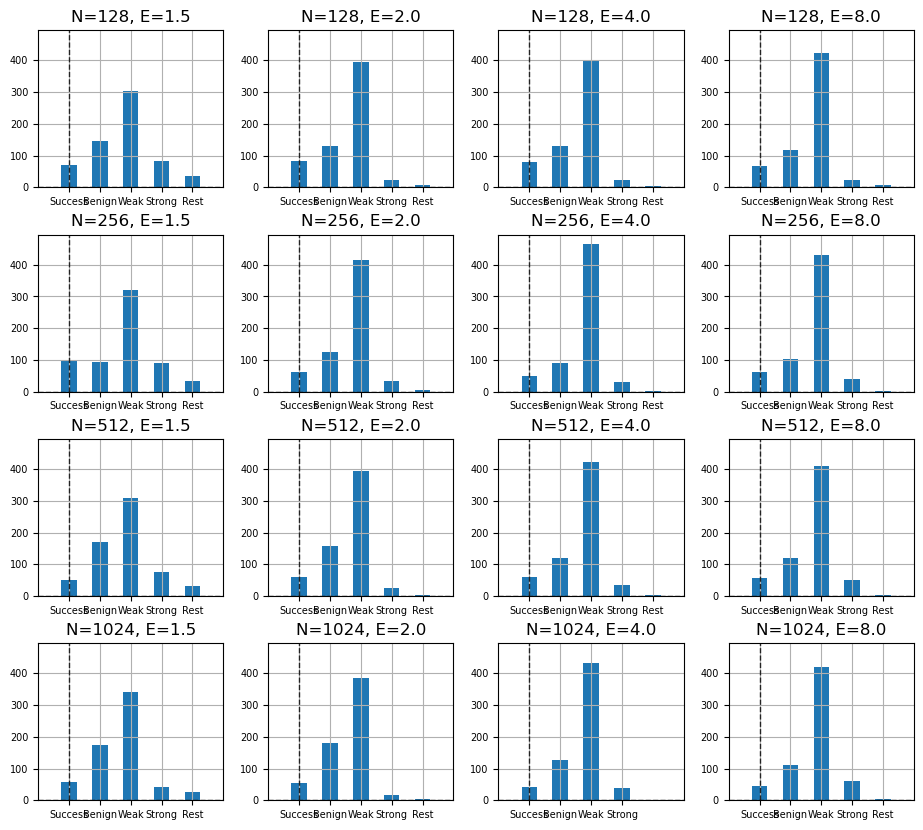

In [27]:
def which_proxy(line):
    deltaCorr = line["correlation_on_max_proxy"] - line["correlation_base"]
    deltaGoal = line["maxed_goal_value"] - line["goal_base"]
    deltaProxy = line["maxed_proxy_value"] - line["proxy_base"]

    name_prox = pd.Series('Rest', index=line.index)  # default empty string

    cond_success = (deltaCorr > 0) & (deltaGoal > 0)
    cond_benign  = (deltaCorr < 0) & (deltaGoal > deltaProxy) & (deltaProxy > 0)
    cond_weak    = (deltaCorr < 0) & (deltaGoal < deltaProxy) & (deltaGoal > 0)
    cond_strong  = (deltaCorr < 0) & (deltaGoal < 0) & (deltaProxy > 0)

    name_prox.loc[cond_success] = 'Success'
    name_prox.loc[cond_benign]  = 'Benign'
    name_prox.loc[cond_weak]    = 'Weak'
    name_prox.loc[cond_strong]  = 'Strong'
    return name_prox
def function_hist(ax, sub_df):
    values = which_proxy(sub_df)
    order = [x for x in ['Success', 'Benign', 'Weak', 'Strong', 'Rest'] if x in values.unique()]
    validlist = values.value_counts()[order]
    categories = validlist.index
    counts = validlist.values
    scatter = ax.bar(categories, counts, width=0.5)
    X_axis = ''
    Y_axis = ''
    Z_axis = ''
    ax.set_xlim(-1,5)
    ax.set_ylim(0, 450*1.1)
    ax.tick_params(axis='both', which='major', labelsize=7)
    return scatter, X_axis,Y_axis,Z_axis
plot2D_func(df, 'N', 'E', function_hist)

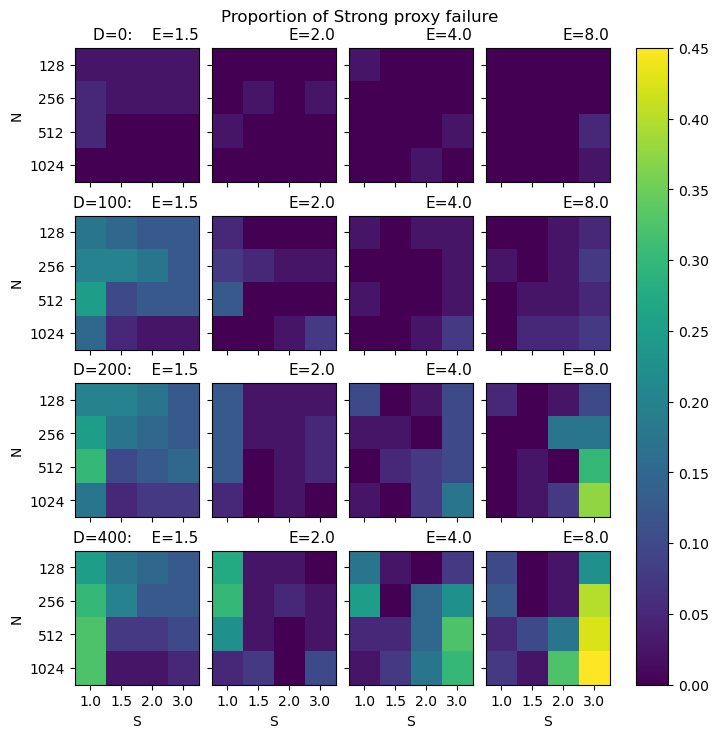

In [68]:
def plot_heatmap_func(df, param1, param2,param3, param4, function_line, title = ""):
    ''' find all possible values of param1 and param2 in the dataframe df
        then for each combination of param1 and param2, make a scatter plot along the other two parameters
        and color the points according to param_for_color
    '''

    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param3_values = df[param3].unique() 
    param4_values = df[param4].unique()
    cm = 1.5* 1/2.54
    param_combinations = list(product(param1_values, param2_values))
    fig, axes = plt.subplots(len(param1_values), len(param2_values), figsize=(12*cm, 12*cm), sharex=True, sharey=True, layout='compressed')
    #search for the maximum and minimum of param_for_color
    param_range = range(len(param_combinations))
    Ms = [np.zeros((len(param3_values), len(param4_values))) for k in param_range]

    
    for k in param_range:
        (p1, p2 )= param_combinations[param_range[k]]
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]


        # create all combinations of param3 and param4
        
        param3_4_combinations = list(product(param3_values, param4_values))
        param_range_34 = range(len(param3_4_combinations))
        for j in param_range_34:
            (p3, p4) = param3_4_combinations[param_range_34[j]]
            subsub_df = sub_df[(sub_df[param3] == p3) & (sub_df[param4] == p4)]
            
            prop = function_line(subsub_df)

            Ms[k][param3_values.tolist().index(p3), param4_values.tolist().index(p4)] = prop

        # make a colormap of M
        cmax = max([np.max(Ms[k]) for k in range(len(param_combinations))])
        cmin = min([np.min(Ms[k]) for k in range(len(param_combinations))])
    for k in param_range:
        (p1, p2 )= param_combinations[param_range[k]]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]
        ax.grid(False)
        c = ax.imshow(Ms[k], origin='lower', vmin=cmin, vmax=cmax, cmap='viridis', aspect='auto')

        #ax.scatter(grouped[param3], grouped[param4], alpha = 0.7, color = plt.cm.viridis((grouped[param_for_color] - min_color) / (max_color - min_color)))
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel(param3)
            ax.set_yticks([0,1,2,3],param3_values) 
            ax.set_title(f'{param1}={p1}:    {param2}={p2}', fontsize = 11, loc='right')
        else:
            ax.set_title(f'{param2}={p2}', fontsize = 11, loc='right')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel(param4)
            ax.set_xticks([0,1,2,3],param4_values)
        ax.invert_yaxis()

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=cmin, vmax=cmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
    if title == "":
        title = "Proportion of " +function_line.__name__.replace("prop_","").capitalize() + " proxy failure"
    #cbar.set_label(title, fontsize = 11)
    fig.suptitle(title, fontsize = 12, y=1.02)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig("test.pdf")
    plt.show()

def compute_deltas(line):
    deltaCorr = line["correlation_on_max_proxy"] - line["correlation_base"]
    deltaGoal = line["maxed_goal_value"] - line["goal_base"]
    deltaProxy = line["maxed_proxy_value"] - line["proxy_base"]
    return deltaCorr, deltaGoal, deltaProxy
def prop_strong(line):
    deltaCorr, deltaGoal, deltaProxy = compute_deltas(line)
    cond_strong  = (deltaCorr < 0) & (deltaGoal < 0) & (deltaProxy > 0)
    return cond_strong.sum() / len(line)

def prop_weak(line):
    deltaCorr, deltaGoal, deltaProxy = compute_deltas(line)
    cond_weak    = (deltaCorr < 0) & (deltaGoal < deltaProxy) & (deltaGoal > 0)
    return cond_weak.sum() / len(line)
def prop_benign(line):
    deltaCorr, deltaGoal, deltaProxy = compute_deltas(line)
    cond_benign  = (deltaCorr < 0) & (deltaGoal > deltaProxy) & (deltaProxy > 0)
    return cond_benign.sum() / len(line)
def prop_no(line):
    deltaCorr, deltaGoal, deltaProxy = compute_deltas(line)
    cond_success = (deltaCorr > 0) & (deltaGoal > 0)
    return cond_success.sum() / len(line)
plot_heatmap_func(df, 'D', 'E', 'N', 'S',  prop_strong)

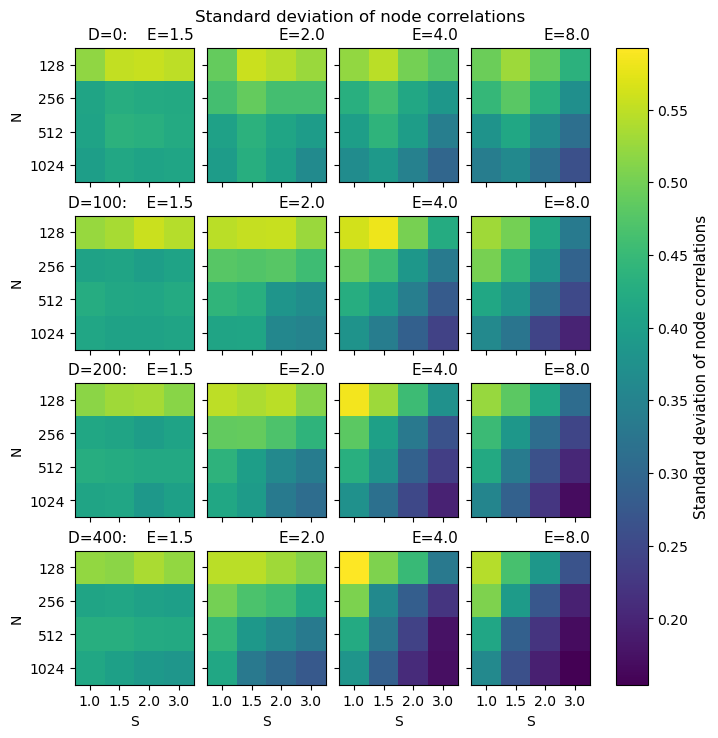

In [59]:
def standard_deviation(line):
    std_list= []
    for index, row in line.iterrows():
        text = row['bin_indices_on_base_correlation'][1:-1]
        bin_vals = [int(k) for k in text.split(',')]
        values = [-1+(k+0.5)/(len(bin_vals))*2 for k in range(len(bin_vals))]
        std = np.sqrt(np.cov(values, aweights=bin_vals))
        std_list.append(std)
    return np.mean( std_list)

plot_heatmap_func(df, 'D', 'E', 'N', 'S', standard_deviation, title = "Standard deviation of node correlations")